<a href="https://colab.research.google.com/github/LuigiElo/DL-PINNs/blob/main/mainJacob.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Initial version

In [5]:
!pip install datasets
!pip install transformers
!pip install deepxde

In [2]:
# Modules to be loaded and used
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import torch
from torch import nn
import math
from functools import partial
from pathlib import Path
from tqdm import tqdm
import rich
from typing import List, Tuple, Optional, Dict, Any
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import transformers
import tokenizers
import datasets
import zipfile
from huggingface_hub import hf_hub_download

from __future__ import division
from __future__ import print_function

import numpy as np
import deepxde as dde
from deepxde.backend import tf
from scipy.integrate import odeint
import re


from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


# (a) Function approximation
## 1D

Compiling model...
Building feed-forward neural network...


/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'build' took 0.372427 s

'compile' took 0.610418 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [3.47e-01]    [6.17e-01]    [1.12e+00]    
1000      [2.87e-05]    [5.51e-01]    [1.05e+00]    
2000      [2.53e-06]    [6.04e-01]    [1.10e+00]    
3000      [1.87e-06]    [6.16e-01]    [1.11e+00]    
4000      [1.37e-06]    [6.12e-01]    [1.11e+00]    
5000      [5.66e-06]    [5.99e-01]    [1.10e+00]    
6000      [1.10e-06]    [5.93e-01]    [1.09e+00]    
7000      [9.82e-07]    [5.80e-01]    [1.08e+00]    
8000      [4.19e-06]    [5.68e-01]    [1.07e+00]    
9000      [9.34e-07]    [5.56e-01]    [1.06e+00]    
10000     [5.93e-07]    [5.45e-01]    [1.05e+00]    

Best model at step 10000:
  train loss: 5.93e-07
  test loss: 5.45e-01
  test metric: [1.05e+00]

'train' took 6.438365 s

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


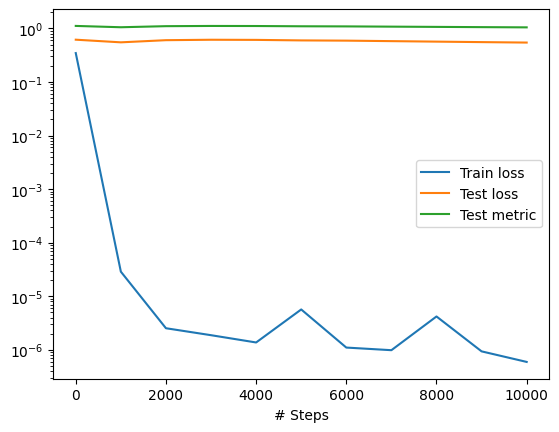

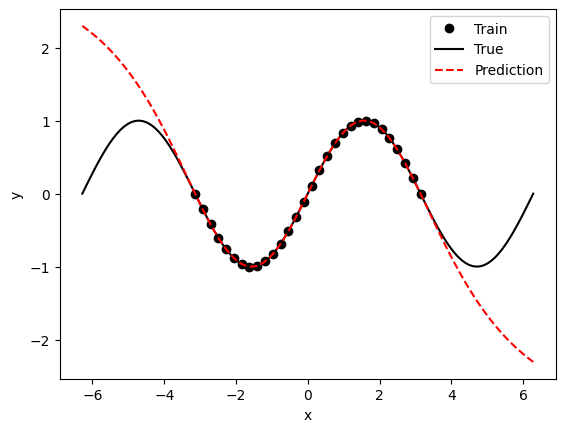

In [4]:
n = 30
a = 1
b = 5
c = 1
N = np.pi
X  = np.linspace(-N,N,n)
#y  = a*X**3 + b*X**2 + c*X
y = np.sin(X)

Xtest = np.linspace(-2*N,2*N,4*n)
#ytest = a*Xtest**3 + b*Xtest**2 + c*Xtest
ytest = np.sin(Xtest)

# function approximation, test outside parameter domain
data1D = dde.data.DataSet(
    X_train=np.reshape(X, (-1, 1)),
    y_train=np.reshape(y, (-1, 1)),
    X_test=np.reshape(Xtest, (-1, 1)),
    y_test=np.reshape(ytest, (-1, 1)),
    col_x=(0,),
    col_y=(1,),
)

layer_size = [1] + 3*[20] + [1]
activation = "tanh"
initializer = "Glorot normal"
net = dde.maps.FNN(layer_size, activation, initializer)

model1 = dde.Model(data1D, net)
model1.compile("adam", lr = 0.001, metrics=["l2 relative error"])
losshistory, train_state = model1.train(epochs=10000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)


## 2D

Compiling model...
Building feed-forward neural network...
'build' took 0.060085 s

'compile' took 0.247283 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [5.46e-01]    [5.24e-01]    [1.02e+00]    
1000      [1.07e-03]    [1.07e-01]    [4.63e-01]    
2000      [1.63e-04]    [5.51e-02]    [3.32e-01]    
3000      [6.23e-05]    [4.53e-02]    [3.01e-01]    
4000      [4.11e-05]    [4.04e-02]    [2.84e-01]    
5000      [1.14e-04]    [3.87e-02]    [2.78e-01]    

Best model at step 4000:
  train loss: 4.11e-05
  test loss: 4.04e-02
  test metric: [2.84e-01]

'train' took 5.232016 s

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


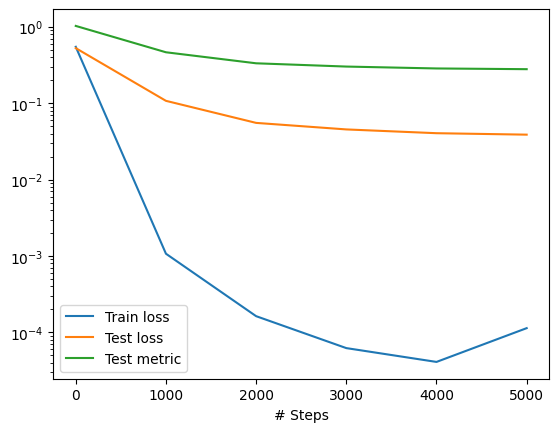

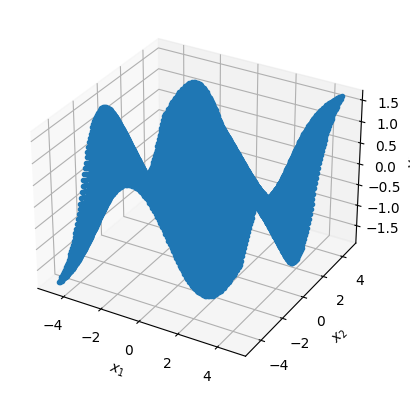

In [5]:
n = 30
N = np.pi

# the function that I'm going to plot
def y_func(X1,X2):
 return np.sin(X1+X2)

x1 = np.linspace(-N,N,n)
x2 = x1

X1,X2 = meshgrid(x1, x2) # grid of point
y = y_func(X1, X2) # evaluation of the function on the grid

x1test = np.linspace(-1.5*N,1.5*N,4*n)
x2test = x1test

X1test,X2test = meshgrid(x1test, x2test) # grid of point
ytest = y_func(X1test, X2test) # evaluation of the function on the grid


# function approximation, test outside parameter domain
data2D = dde.data.DataSet(
    X_train = np.hstack(( np.reshape(X1, (-1, 1)),np.reshape(X2, (-1, 1)) )),
    y_train = np.reshape(y, (-1, 1)),
    X_test = np.hstack(( np.reshape(X1test, (-1, 1)),np.reshape(X2test, (-1, 1)) )),
    y_test = np.reshape(ytest, (-1, 1)),
    col_x = (0,),
    col_y = (1,),
)

layer_size = [2] + [20] * 3 + [1]
activation = "tanh"
initializer = "Glorot normal"
net = dde.maps.FNN(layer_size, activation, initializer)

model2 = dde.Model(data2D, net)
model2.compile("adam", lr = 0.001, metrics=["l2 relative error"])
losshistory, train_state = model2.train(epochs=5000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)


# (b)

## 1D

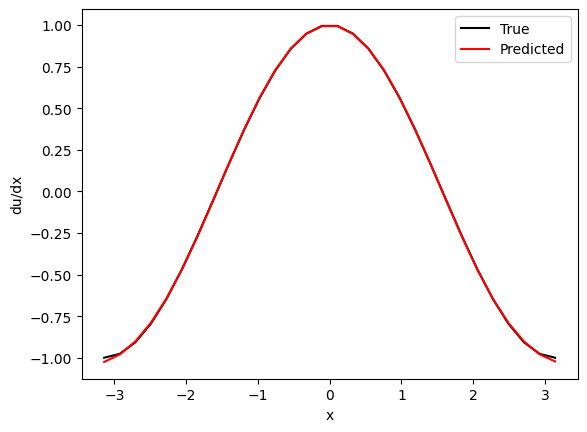

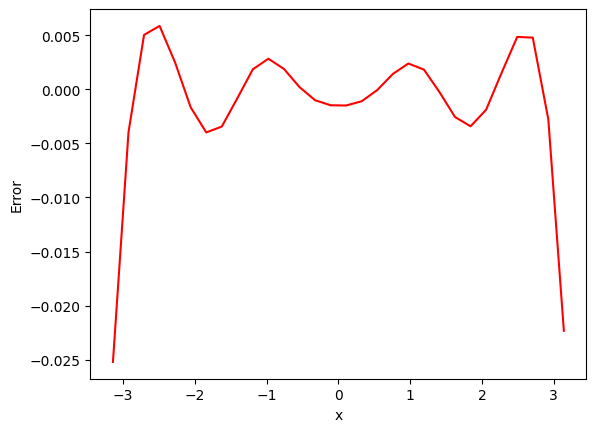

In [6]:
# compute gradient of solution
def dudx(x, u):
  return dde.grad.jacobian(u, x, i=0)

du_dx = model1.predict(np.reshape(X, (-1, 1)), operator=dudx)

yx = np.cos(np.reshape(X, (-1, 1)))

plt.figure()
plt.plot(X,yx,'k',label='True')
plt.plot(np.reshape(X, (-1, 1)),du_dx,'r',label='Predicted')
plt.xlabel('x')
plt.ylabel('du/dx')
plt.legend()
plt.show()

plt.figure()
plt.plot(X,du_dx-np.reshape(yx,(-1,1)),'r')
plt.xlabel('x')
plt.ylabel('Error')
plt.show()

##2D

(900, 1) (900, 1) (900, 1) (900, 1)


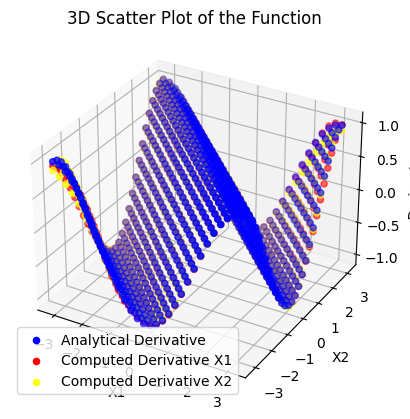

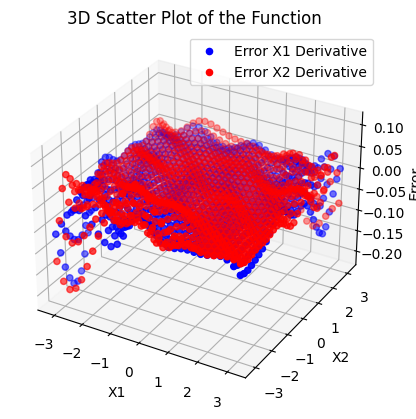

In [7]:
# compute gradient of solution
def dudx(x, u):
  return dde.grad.jacobian(u, x, i=0)

du_dx1 = model2.predict(np.hstack(( np.reshape(X1, (-1, 1)),np.reshape(X2, (-1, 1)) )) , operator=dudx)

#du_dx1[:,0] and du_dx[:,1] are the computed derivatives for each variable in each point belonging to X

#the analytical derivate for both variables is exactly the same
yx = np.cos(np.reshape(X1, (-1, 1))+np.reshape(X2, (-1, 1)))

du_dx10=du_dx1[:,0]
du_dx10 = du_dx10.reshape(-1, 1)

du_dx11=du_dx1[:,1]
du_dx11 = du_dx11.reshape(-1, 1)
#yx = yx.reshape(-1, 1)

print(np.shape(du_dx10),np.shape(yx),np.shape(np.reshape(X1, (-1, 1))),np.shape(np.reshape(X2, (-1, 1))))

loss0=du_dx10-yx
loss1=du_dx11-yx

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(np.reshape(X1, (-1, 1)),np.reshape(X2, (-1, 1)), yx, marker='o', label='Analytical Derivative', color='blue')
ax.scatter(np.reshape(X1, (-1, 1)),np.reshape(X2, (-1, 1)), du_dx10, marker='o', label='Computed Derivative X1', color='red')
ax.scatter(np.reshape(X1, (-1, 1)),np.reshape(X2, (-1, 1)), du_dx11, marker='o', label='Computed Derivative X2', color='yellow')

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Derivative')
plt.title('3D Scatter Plot of the Function')
plt.legend()
plt.show()

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(np.reshape(X1, (-1, 1)),np.reshape(X2, (-1, 1)), loss0, marker='o', label='Error X1 Derivative', color='blue')
ax.scatter(np.reshape(X1, (-1, 1)),np.reshape(X2, (-1, 1)), loss1, marker='o', label='Error X2 Derivative', color='red')

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Error')
plt.title('3D Scatter Plot of the Function')
plt.legend()
plt.show()

# (c)

## 1D

Compiling model...
Building feed-forward neural network...
'build' took 0.104942 s

'compile' took 0.384648 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [7.04e-01]    [5.91e-01]    [1.09e+00]    
1000      [4.22e-04]    [5.81e-01]    [1.08e+00]    
2000      [6.68e-05]    [5.03e-01]    [1.00e+00]    
3000      [2.06e-05]    [4.60e-01]    [9.59e-01]    
4000      [7.58e-06]    [4.32e-01]    [9.30e-01]    
5000      [2.89e-06]    [4.13e-01]    [9.09e-01]    

Best model at step 5000:
  train loss: 2.89e-06
  test loss: 4.13e-01
  test metric: [9.09e-01]

'train' took 3.688168 s

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


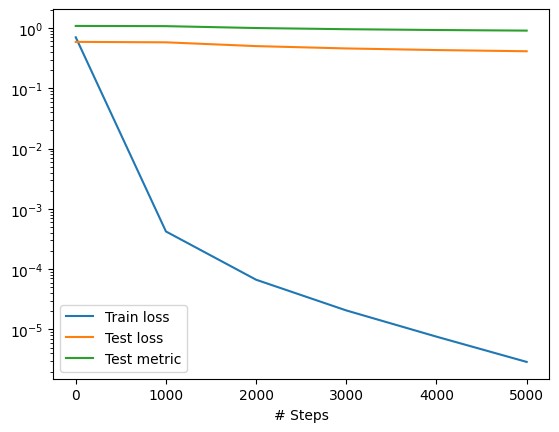

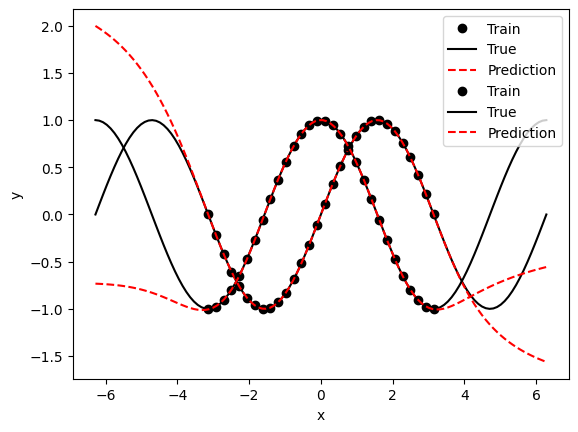

In [8]:
n = 30
X  = np.linspace(-np.pi,np.pi,n)
y  = [np.sin(X),np.cos(X)]

Xtest  = np.linspace(-2*np.pi,2*np.pi,4*n)
ytest  = [np.sin(Xtest),np.cos(Xtest)]

# reshaping output training data
y1 = np.asmatrix(y[0]).transpose()
y2 = np.asmatrix(y[1]).transpose()
ynew = np.concatenate((y1,y2),axis=1)
ynew = np.asarray(ynew)

# reshaping output test data
ytest1 = np.asmatrix(ytest[0]).transpose()
ytest2 = np.asmatrix(ytest[1]).transpose()
ytestnew = np.concatenate((ytest1,ytest2),axis=1)
ytestnew = np.asarray(ytestnew)


# function approximation, test outside parameter domain
data1Dg = dde.data.DataSet(
    X_train=np.reshape(X, (-1, 1)),
    y_train=ynew,
    X_test=np.reshape(Xtest, (-1, 1)),
    y_test=ytestnew,
    col_x=(0,),
    col_y=(1,),
)

layer_size = [1] + [20] * 3 + [2]
activation = "tanh"
initializer = "Glorot normal"
net = dde.maps.FNN(layer_size, activation, initializer)

model = dde.Model(data1Dg, net)
model.compile("adam", lr = 0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=5000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

## 2D

Compiling model...
Building feed-forward neural network...
'build' took 0.063919 s

'compile' took 0.253396 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [7.06e-01]    [7.86e-01]    [1.25e+00]    
1000      [2.11e-03]    [5.30e-01]    [1.03e+00]    
2000      [4.66e-04]    [4.60e-01]    [9.59e-01]    
3000      [1.41e-04]    [4.09e-01]    [9.04e-01]    
4000      [6.87e-05]    [3.90e-01]    [8.84e-01]    
5000      [4.31e-05]    [3.83e-01]    [8.75e-01]    

Best model at step 5000:
  train loss: 4.31e-05
  test loss: 3.83e-01
  test metric: [8.75e-01]

'train' took 4.888114 s

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


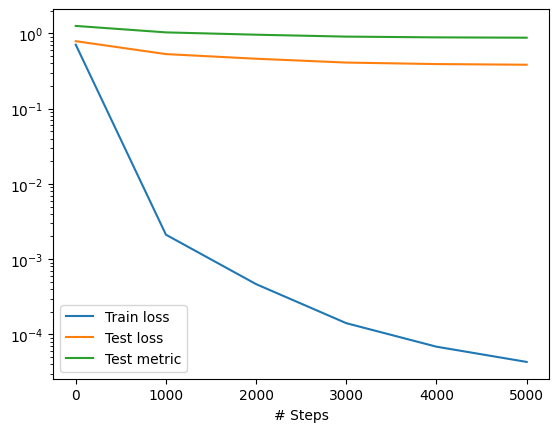

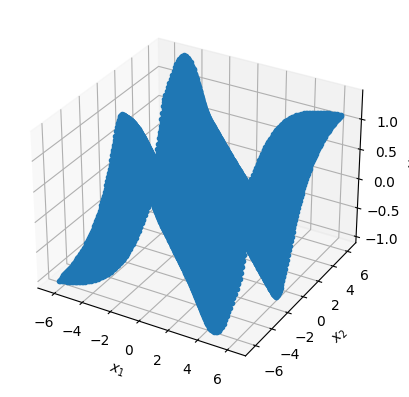

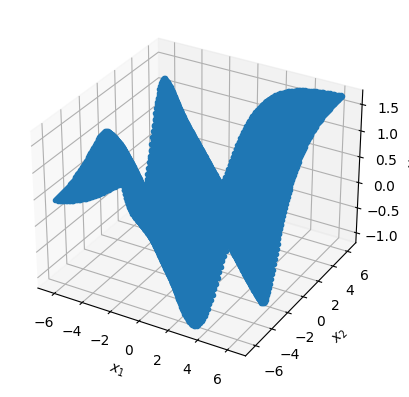

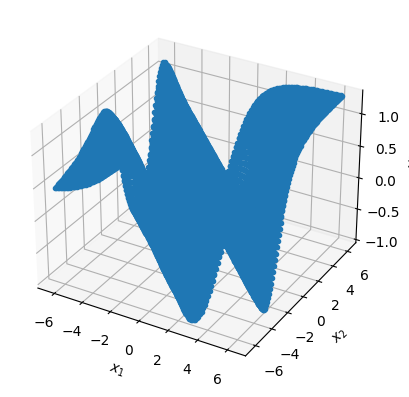

In [9]:
n = 30
N = np.pi

# the function that I'm going to plot
def y_func(X1,X2):
 return np.sin(X1+X2)

def y_grad(X1,X2):
 return np.cos(X1+X2),np.cos(X1+X2)

x1 = np.linspace(-N,N,n)
x2 = x1

X1,X2 = meshgrid(x1, x2) # grid of points
y = y_func(X1, X2) # evaluation of the function on the grid
yg = y_grad(X1,X2) # evaluation of the gradient on the grid

# Collecting and reshaping training function val and gradient val into one output:
y = np.hstack((np.reshape(y, (-1, 1)), np.reshape(yg[0], (-1, 1)), np.reshape(yg[1], (-1, 1)) ))


x1test = np.linspace(-2*N,2*N,4*n)
x2test = x1test

X1test,X2test = meshgrid(x1test, x2test) # grid of point
ytest = y_func(X1test, X2test) # evaluation of the function on the grid
ytestg = y_grad(X1test,X2test) # evaluation of the gradient on the grid

# Collecting and reshaping testing output function val and gradient val into one output:
ytest = np.hstack((np.reshape(ytest, (-1, 1)), np.reshape(ytestg[0], (-1, 1)), np.reshape(ytestg[1], (-1, 1)) ))




# function approximation, test outside parameter domain
data2Dg = dde.data.DataSet(
    X_train = np.hstack(( np.reshape(X1, (-1, 1)),np.reshape(X2, (-1, 1)) )),
    y_train = y,
    X_test = np.hstack(( np.reshape(X1test, (-1, 1)),np.reshape(X2test, (-1, 1)) )),
    y_test = ytest,
    col_x = (0,),
    col_y = (1,),
)

layer_size = [2] + [20] * 3 + [3]
activation = "tanh"
initializer = "Glorot normal"
net = dde.maps.FNN(layer_size, activation, initializer)

model = dde.Model(data2Dg, net)
model.compile("adam", lr = 0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=5000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

##d)

##1D

In [7]:
def test_dataset1D():
  n=30
  N = np.pi
  X  = np.linspace(-2*N,2*N,n)
  #y  = a*X**3 + b*X**2 + c*X
  y = np.sin(X)
  return X,y

In [56]:
import time

def create_model1D(n_data_train,n_layers,n_neurons):
  a = 1
  b = 5
  c = 1
  N = np.pi
  X  = np.linspace(-N,N,n_data_train)
  #y  = a*X**3 + b*X**2 + c*X
  y = np.sin(X)

  Xtest = np.linspace(N,3*N,n)
  #ytest = a*Xtest**3 + b*Xtest**2 + c*Xtest
  ytest = np.sin(Xtest)

  # function approximation, test outside parameter domain
  data1D = dde.data.DataSet(
      X_train=np.reshape(X, (-1, 1)),
      y_train=np.reshape(y, (-1, 1)),
      X_test=np.reshape(Xtest, (-1, 1)),
      y_test=np.reshape(ytest, (-1, 1)),
      col_x=(0,),
      col_y=(1,),
  )

  layer_size = [1] + n_layers*[n_neurons] + [1]
  activation = "tanh"
  initializer = "Glorot normal"
  net = dde.maps.FNN(layer_size, activation, initializer)

  model1 = dde.Model(data1D, net)
  model1.compile("adam", lr = 0.001, metrics=["l2 relative error"])
  start_time = time.time()
  losshistory, train_state = model1.train(epochs=10000)
  end_time = time.time()
  #dde.saveplot(losshistory, train_state, issave=True, isplot=True)

  return model1,(end_time-start_time)

In [13]:
# the accuracy will be studied in 4 possible scenarios: 1 layer, 20 units | 1 layer 32 units | 2 layers, 20 units | 2 layers 32 units

X,Y= test_dataset1D() #test dataset generated
Y=np.reshape(Y, (-1, 1))

losses_models=[]
n_values=[]
param_config= [[1,20],[1,32],[2,20],[2,32]] #possible parameters configurations
#each iteration in the loop will have different dataset size with steps of 5. We will start from n=10 till n=100
for n in range(5, 101, 5):
  losses_configs=[]
  for conf in param_config:
    print(conf)
    #n=20
    model,_= create_model1D(n,conf[0],conf[1]) # training set size = n, number of hidden layers= 1, number of hidden units per layer=20
    print()
    #print(X,Y)
    pred=model.predict(np.reshape(X, (-1, 1)))
    loss=pred-Y
    losses_configs.append(abs(np.mean(loss)))

  n_values.append(n)
  losses_models.append(losses_configs)
  print(f"Loss calculated for model feeded with dataset size {n}...")

[1, 20]
Compiling model...
Building feed-forward neural network...
'build' took 0.038318 s

'compile' took 0.145747 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


Training model...

Step      Train loss    Test loss     Test metric   
0         [7.89e-01]    [1.20e+00]    [1.73e+00]    
1000      [3.56e-03]    [3.84e+00]    [3.10e+00]    
2000      [3.65e-10]    [4.98e+00]    [3.53e+00]    
3000      [1.89e-12]    [4.98e+00]    [3.53e+00]    
4000      [2.76e-07]    [4.98e+00]    [3.53e+00]    
5000      [1.06e-10]    [4.98e+00]    [3.53e+00]    
6000      [1.31e-08]    [4.98e+00]    [3.53e+00]    
7000      [2.53e-09]    [4.98e+00]    [3.53e+00]    
8000      [5.80e-12]    [4.98e+00]    [3.53e+00]    
9000      [1.97e-07]    [4.98e+00]    [3.53e+00]    
10000     [1.06e-08]    [4.98e+00]    [3.53e+00]    

Best model at step 3000:
  train loss: 1.89e-12
  test loss: 4.98e+00
  test metric: [3.53e+00]

'train' took 5.101472 s


[1, 32]
Compiling model...
Building feed-forward neural network...
'build' took 0.031086 s

'compile' took 0.148651 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [9.51e-01]    [1.63e

In [52]:
print(np.shape(losses_models))

loss_final1=[]
loss_final2=[]
loss_final3=[]
loss_final4=[]
for el in range(np.shape(losses_models)[0]): #20
  loss_final1.append(losses_models[el][0])
  loss_final2.append(losses_models[el][1])
  loss_final3.append(losses_models[el][2])
  loss_final4.append(losses_models[el][3])

print(loss_final1)

(20, 4)
[0.057795297106107056, 0.17045710980892181, 0.03401824732621508, 0.020514205098152192, 0.00010287413994468272, 0.03822515805562334, 0.05221090316772463, 0.003811014195283224, 0.005258318781852722, 0.02844442327817278, 0.14373231530189512, 0.0021665434042613006, 0.04432655374209083, 0.02687613070011136, 0.021234171092510253, 0.016864131887753774, 0.010502294699350963, 0.04041380236546196, 0.00716978708902997, 0.04393704136212664]


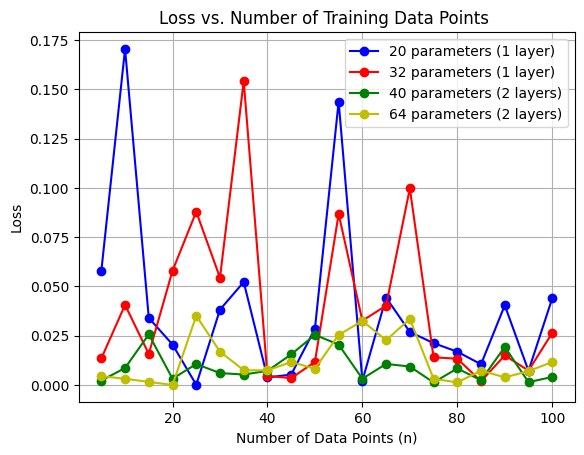

In [55]:
# Create a plot of accuracy vs. `n`
plt.figure()
plt.plot(n_values, loss_final1, marker='o', linestyle='-', color='b', label= '20 parameters (1 layer)')
plt.plot(n_values, loss_final2, marker='o', linestyle='-', color='r', label= '32 parameters (1 layer)')
plt.plot(n_values, loss_final3 , marker='o', linestyle='-', color='g', label= '40 parameters (2 layers)')
plt.plot(n_values, loss_final4 , marker='o', linestyle='-', color='y', label= '64 parameters (2 layers)')
plt.title('Loss vs. Number of Training Data Points ')
plt.xlabel('Number of Data Points (n)')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()



##2D


In [10]:
def test_dataset2D():

  n=30
  N = np.pi
  x1 = np.linspace(-2*N,2*N,n)
  x2 = x1

  X1,X2 = meshgrid(x1, x2) # grid of point

  #y  = a*X**3 + b*X**2 + c*X
  y = np.sin(X1+X2)
  return X1,X2,y

In [11]:
def create_model2D(n_data_train,n_layers,n_neurons):
  N = np.pi
  x1 = np.linspace(-N,N,n)
  x2 = x1

  X1,X2 = meshgrid(x1, x2) # grid of point
  y =  np.sin(X1+X2)

  x1test = np.linspace(-1.5*N,1.5*N,n)
  x2test = x1test

  X1test,X2test = meshgrid(x1test, x2test) # grid of point
  ytest = np.sin(X1test+X2test) # evaluation of the function on the grid


  # function approximation, test outside parameter domain
  data2D = dde.data.DataSet(
      X_train = np.hstack(( np.reshape(X1, (-1, 1)),np.reshape(X2, (-1, 1)) )),
      y_train = np.reshape(y, (-1, 1)),
      X_test = np.hstack(( np.reshape(X1test, (-1, 1)),np.reshape(X2test, (-1, 1)) )),
      y_test = np.reshape(ytest, (-1, 1)),
      col_x = (0,),
      col_y = (1,),
  )

  layer_size = [2] + n_layers*[n_neurons] + [1]
  activation = "tanh"
  initializer = "Glorot normal"
  net = dde.maps.FNN(layer_size, activation, initializer)

  model2 = dde.Model(data2D, net)
  model2.compile("adam", lr = 0.001, metrics=["l2 relative error"])
  start_time = time.time()
  losshistory, train_state = model2.train(epochs=5000)
  end_time = time.time()

  return model2,(end_time-start_time)

In [4]:
X1,X2,Y= test_dataset2D() #test dataset generated
Y=np.reshape(Y, (-1, 1))


NameError: ignored

In [ ]:
import time
# the accuracy will be studied in 4 possible scenarios: 1 layer, 20 units | 1 layer 32 units | 2 layers, 20 units | 2 layers 32 units

X1,X2,Y= test_dataset2D() #test dataset generated
Y=np.reshape(Y, (-1, 1))

losses_models=[]
n_values=[]
param_config= [[1,20],[1,32],[2,20],[2,32]] #possible parameters configurations
#each iteration in the loop will have different dataset size with steps of 5. We will start from n=10 till n=100
for n in range(5, 101, 5):
  losses_configs=[]
  for conf in param_config:
    print(conf)
    model,_= create_model2D(n,conf[0],conf[1]) # training set size = n, number of hidden layers= 1, number of hidden units per layer=20
    #print(X,Y)
    pred=model.predict(np.hstack(( np.reshape(X1, (-1, 1)), np.reshape(X2, (-1, 1)) )))
    loss=pred-Y
    losses_configs.append(abs(np.mean(loss)))

  n_values.append(n)
  losses_models.append(losses_configs)
  print(f"Loss calculated for model feeded with dataset size {n}...")

[1, 20]
Compiling model...
Building feed-forward neural network...
'build' took 0.044051 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.336061 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [4.23e-01]    [6.06e-01]    [1.12e+00]    
1000      [5.19e-03]    [6.56e-01]    [1.17e+00]    
2000      [1.54e-06]    [6.81e-01]    [1.19e+00]    
3000      [1.55e-08]    [6.79e-01]    [1.19e+00]    
4000      [1.37e-09]    [6.79e-01]    [1.19e+00]    
5000      [1.13e-07]    [6.79e-01]    [1.19e+00]    

Best model at step 4000:
  train loss: 1.37e-09
  test loss: 6.79e-01
  test metric: [1.19e+00]

'train' took 11.668299 s

[1, 32]
Compiling model...
Building feed-forward neural network...
'build' took 0.033863 s

'compile' took 1.284308 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [7.01e-01]    [9.08e-01]    [1.38e+00]    
1000      [2.39e-02]    [5.65e-01]    [1.09e+00]    
2000      [4.03e-06]    [7.32e-01]    [1.24e+00]    
3000      [9.75e-12]    [7.33e-01]    [1.24e+00]    
4000      [2.89e-11]    [7.33e-01]    [1.24e+00]    
500

In [8]:
print(np.shape(losses_models))

loss_final1=[]
loss_final2=[]
loss_final3=[]
loss_final4=[]
for el in range(np.shape(losses_models)[0]): #20
  loss_final1.append(losses_models[el][0])
  loss_final2.append(losses_models[el][1])
  loss_final3.append(losses_models[el][2])
  loss_final4.append(losses_models[el][3])

print(loss_final1)

(20, 4)
[0.2638568873206774, 0.25865992907020774, 1.57669373013907, 0.32115641608834267, 0.19969745639297698, 0.6575627369350857, 0.04773078746265832, 0.020317724943161034, 0.13647005885839464, 0.6907255679037836, 0.7624585216823552, 0.5417025466097727, 0.8725233525037766, 0.13720473683542675, 0.017699227597978352, 1.6176358181900448, 0.7058127162191603, 0.9234890923897425, 0.5029886701951424, 0.26132195873806874]


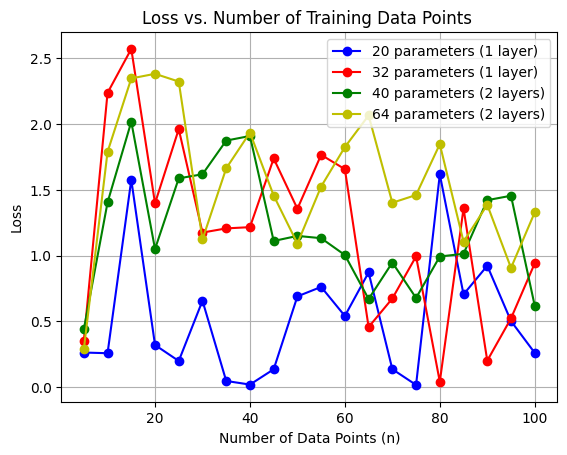

In [9]:
# Create a plot of accuracy vs. `n`
plt.figure()
plt.plot(n_values, loss_final1, marker='o', linestyle='-', color='b', label= '20 parameters (1 layer)')
plt.plot(n_values, loss_final2, marker='o', linestyle='-', color='r', label= '32 parameters (1 layer)')
plt.plot(n_values, loss_final3 , marker='o', linestyle='-', color='g', label= '40 parameters (2 layers)')
plt.plot(n_values, loss_final4 , marker='o', linestyle='-', color='y', label= '64 parameters (2 layers)')
plt.title('Loss vs. Number of Training Data Points ')
plt.xlabel('Number of Data Points (n)')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

##e)

##1D

In [62]:
#we will study the training/test time

param_config= [[1,20],[1,32],[2,20],[1,48],[2,32],[2,48]] #possible parameters configurations
X,Y= test_dataset1D() #test dataset generated

train_times=[]
test_times=[]
n_parameters=[]

for conf in param_config:
  model,train_time= create_model1D(50,conf[0],conf[1])
  start_time= time.time()
  pred=model.predict(np.reshape(X, (-1, 1)))
  end_time= time.time()
  train_times.append(train_time)
  test_times.append(end_time-start_time)
  n_parameters.append(conf[0]*conf[1])



Compiling model...
Building feed-forward neural network...
'build' took 0.039321 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.496409 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.07e+00]    [9.10e-01]    [1.36e+00]    
1000      [2.82e-02]    [6.83e-01]    [1.17e+00]    
2000      [2.70e-03]    [1.38e+00]    [1.67e+00]    
3000      [1.73e-04]    [1.90e+00]    [1.96e+00]    
4000      [1.71e-05]    [2.10e+00]    [2.06e+00]    
5000      [4.08e-06]    [2.18e+00]    [2.10e+00]    
6000      [2.65e-06]    [2.20e+00]    [2.11e+00]    
7000      [1.74e-06]    [2.22e+00]    [2.12e+00]    
8000      [1.08e-06]    [2.24e+00]    [2.13e+00]    
9000      [7.10e-07]    [2.26e+00]    [2.14e+00]    
10000     [5.39e-07]    [2.27e+00]    [2.14e+00]    

Best model at step 10000:
  train loss: 5.39e-07
  test loss: 2.27e+00
  test metric: [2.14e+00]

'train' took 17.982309 s

Compiling model...
Building feed-forward neural network...
'build' took 0.032198 s

'compile' took 1.454468 s

Training model...

Step      Train loss    Test loss     Test metric   
0         

In [61]:
print(n_parameters)
print(train_times)

[20, 32, 40, 48, 64, 64]
[16.908690690994263, 15.497330904006958, 17.07233428955078, 16.21697235107422, 18.351258516311646, 18.5027494430542]


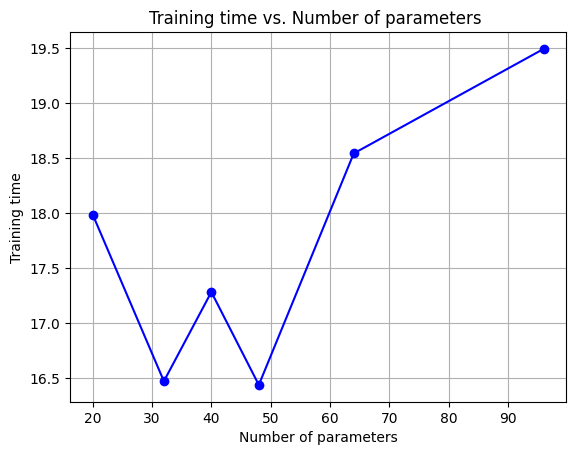

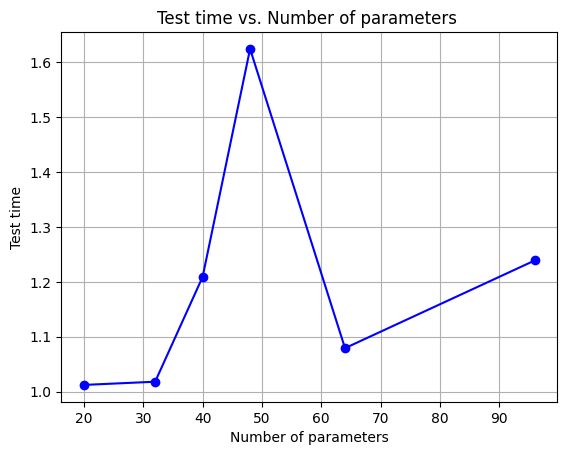

In [64]:
# Create a plot of training time vs. number of parameters
plt.figure()
plt.plot(n_parameters, train_times , marker='o', linestyle='-', color='b')
plt.title('Training time vs. Number of parameters ')
plt.xlabel('Number of parameters')
plt.ylabel('Training time')
plt.grid(True)
plt.show()

# Create a plot of inference time vs. number of parameters
plt.figure()
plt.plot(n_parameters, test_times , marker='o', linestyle='-', color='b')
plt.title('Test time vs. Number of parameters ')
plt.xlabel('Number of parameters')
plt.ylabel('Test time')
plt.grid(True)
plt.show()

##2D

In [9]:
#we will study the training/test time with data training set size 50

param_config= [[1,20],[1,32],[2,20],[1,48],[2,32],[2,48]] #possible parameters configurations
X1,X2,Y= test_dataset2D() #test dataset generated

train_times=[]
test_times=[]
n_parameters=[]

for conf in param_config:
  model,train_time= create_model2D(50,conf[0],conf[1])
  start_time= time.time()
  pred=model.predict(np.hstack(( np.reshape(X1, (-1, 1)),np.reshape(X2, (-1, 1)) )))
  end_time= time.time()
  train_times.append(train_time)
  test_times.append(end_time-start_time)
  n_parameters.append(conf[0]*conf[1])

Compiling model...
Building feed-forward neural network...
'build' took 0.069712 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 3.643312 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.54e+00]    [2.19e+00]    [2.09e+00]    
1000      [4.92e-02]    [8.11e-01]    [1.27e+00]    
2000      [1.74e-02]    [5.61e-01]    [1.06e+00]    
3000      [8.21e-03]    [3.96e-01]    [8.90e-01]    
4000      [5.43e-03]    [3.17e-01]    [7.96e-01]    
5000      [3.93e-03]    [2.56e-01]    [7.16e-01]    

Best model at step 5000:
  train loss: 3.93e-03
  test loss: 2.56e-01
  test metric: [7.16e-01]

'train' took 23.478193 s

Compiling model...
Building feed-forward neural network...
'build' took 0.031922 s

'compile' took 1.918727 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [8.18e-01]    [9.57e-01]    [1.38e+00]    
1000      [2.96e-02]    [7.91e-01]    [1.26e+00]    
2000      [8.16e-03]    [3.59e-01]    [8.47e-01]    
3000      [2.27e-03]    [1.46e-01]    [5.39e-01]    
4000      [7.76e-04]    [5.80e-02]    [3.40e-01]    
5000      [

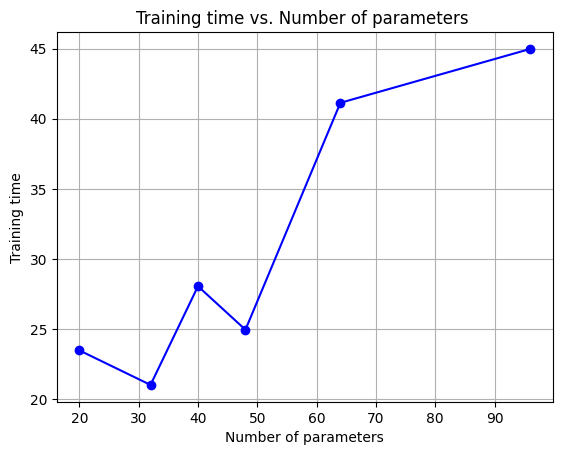

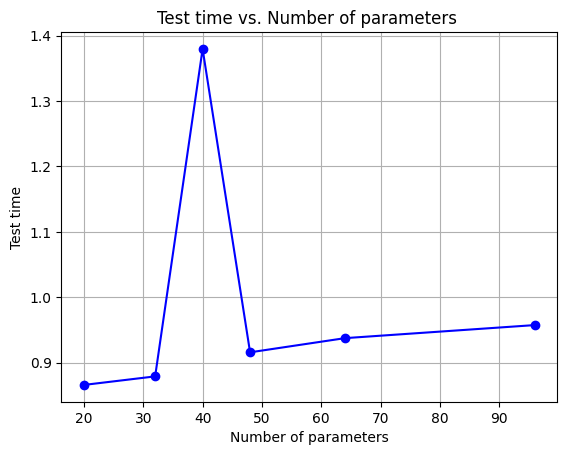

In [11]:
# Create a plot of training time vs. number of parameters
plt.figure()
plt.plot(n_parameters, train_times , marker='o', linestyle='-', color='b')
plt.title('Training time vs. Number of parameters ')
plt.xlabel('Number of parameters')
plt.ylabel('Training time')
plt.grid(True)
plt.show()

# Create a plot of inference time vs. number of parameters
plt.figure()
plt.plot(n_parameters, test_times , marker='o', linestyle='-', color='b')
plt.title('Test time vs. Number of parameters ')
plt.xlabel('Number of parameters')
plt.ylabel('Test time')
plt.grid(True)
plt.show()